# **Summary**
The goal of this assignment is to Predict the total number of Washington D.C. bicycle users on an hourly basis using a dataset (use attached `hour.csv`, and have a look at `README.txt` for explanations)
 with data from 2011 and 2012. The notebook shold be divided in the following sections:

# Importing all libraries/modules used in this notebook:

In [1]:
import calendar
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import date
from functools import reduce
from pylab import *
from sklearn import preprocessing
from sklearn import datasets
from sklearn.datasets import load_diabetes
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from textwrap import wrap

In [2]:
pd.set_option( "display.max_columns", None,'display.max_colwidth', None)

# Reading the Data

In [3]:
data = pd.read_csv("hour.csv")
data.head()

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1


In [4]:
data.rename(columns={'instant':'record_id','dteday':'date', 'hr':'hour','weathersit':'weather_condition',
                       'hum':'humidity','cnt':'total_rentals', "temp":"temperature", "atemp":"atemperature"},inplace=True)

data = data.set_index('record_id')
data['date'] = pd.to_datetime(data["date"])
data

,date,hour,weather_condition,temperature,atemperature,humidity,windspeed,casual,registered,total_rentals
record_id,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0000,3,13,16
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0000,8,32,40
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0000,5,27,32
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0000,3,10,13
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...
17375,2012-12-31,19,"Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",0.26,0.2576,0.60,0.1642,11,108,119
17376,2012-12-31,20,"Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",0.26,0.2576,0.60,0.1642,8,81,89
17377,2012-12-31,21,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.26,0.2576,0.60,0.1642,7,83,90


# **Part 1: Exploratory Data Analysis**

## 1.1. Ensuring data quality

In [5]:
data.shape

(17379, 10)

In [6]:
data.size

173790

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               17379 non-null  datetime64[ns]
 1   hour               17379 non-null  int64         
 2   weather_condition  17279 non-null  object        
 3   temperature        17280 non-null  float64       
 4   atemperature       17279 non-null  float64       
 5   humidity           17279 non-null  float64       
 6   windspeed          17279 non-null  float64       
 7   casual             17379 non-null  int64         
 8   registered         17379 non-null  int64         
 9   total_rentals      17379 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(4), object(1)
memory usage: 1.5+ MB


In [8]:
# Checking missing values for the dataset
data.isnull().sum()

date                   0
hour                   0
weather_condition    100
temperature           99
atemperature         100
humidity             100
windspeed            100
casual                 0
registered             0
total_rentals          0
dtype: int64

In [9]:
data.describe()

,hour,temperature,atemperature,humidity,windspeed,casual,registered,total_rentals
count,17379.000000,17280.000000,17279.000000,17279.000000,17279.000000,17379.000000,17379.000000,17379.000000
mean,11.546752,0.497071,0.475530,0.627235,0.190114,35.676218,153.786869,189.463088
std,6.914405,0.192474,0.171782,0.193047,0.122378,49.305030,151.357286,181.387599
min,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,12.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,18.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,23.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


## 1.2. Plotting clear and meaningful figures

Text(0, 0.5, 'Number of Rides')

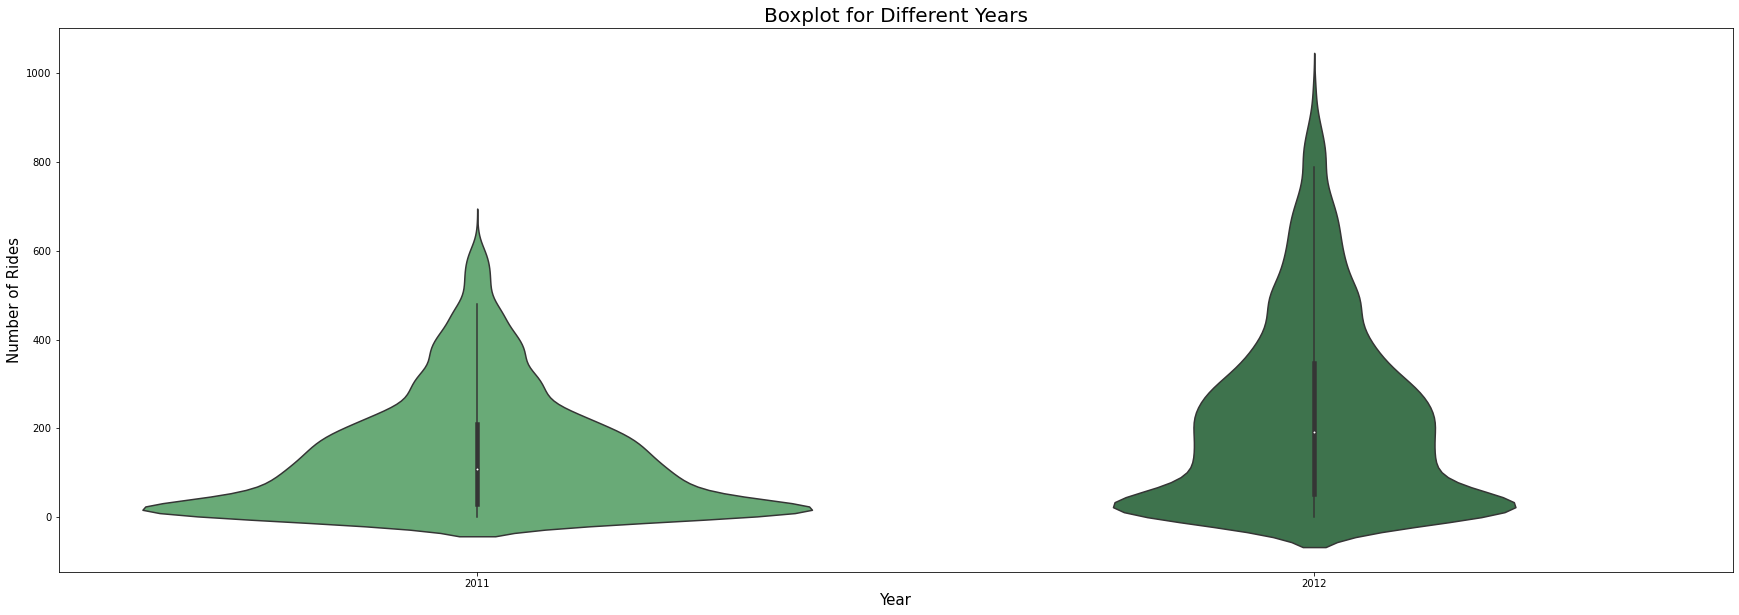

In [10]:
# Total number of passengers by year
fig, (graph1) = plt.subplots(ncols=1, figsize=(30, 10))

sns.violinplot(x=data["date"].dt.year, y="total_rentals", data=data, ax=graph1, palette="Greens_d")
graph1.set_title("Boxplot for Different Years",fontsize = 20)
graph1.set_xlabel("Year" , fontsize = 15)
graph1.set_ylabel("Number of Rides" , fontsize = 15)

Text(0, 0.5, 'Number of Rides')

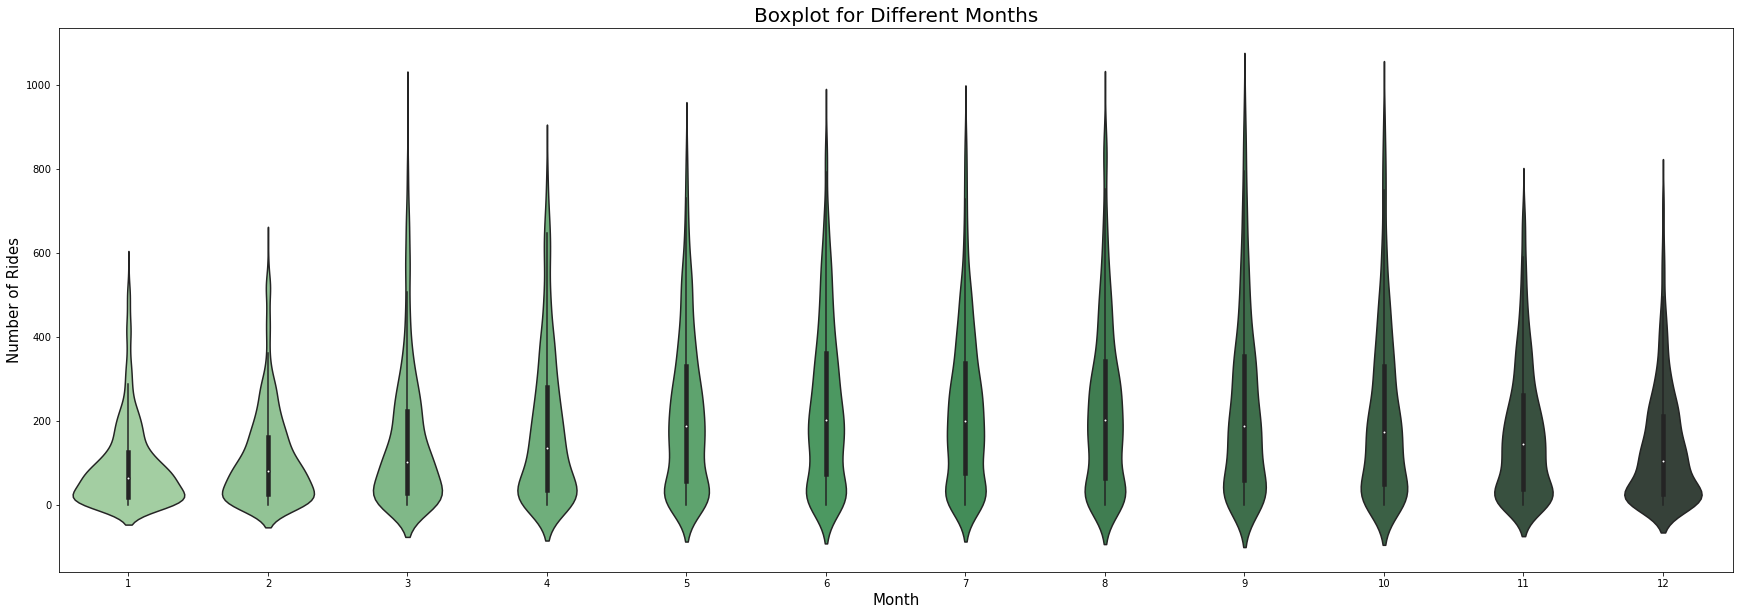

In [11]:
# Total number of passengers by month
fig, (graph1) = plt.subplots(ncols=1, figsize=(30, 10))

sns.violinplot(x=data["date"].dt.month, y="total_rentals", data=data, ax=graph1, palette="Greens_d")
graph1.set_title("Boxplot for Different Months",fontsize = 20)
graph1.set_xlabel("Month" , fontsize = 15)
graph1.set_ylabel("Number of Rides" , fontsize = 15)

Text(0, 0.5, 'Number of Rides')

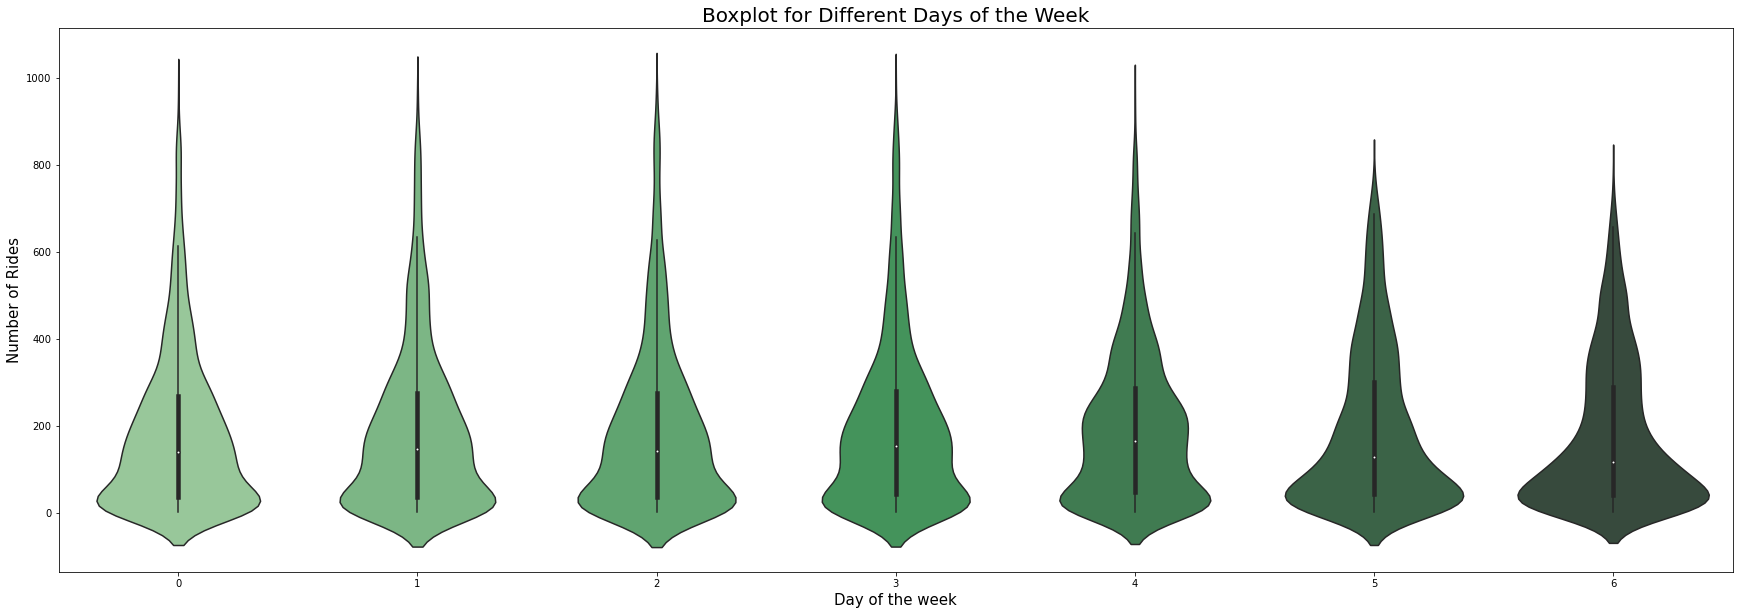

In [12]:
# Total number of passengers by day of the week
fig, (graph1) = plt.subplots(ncols=1, figsize=(30, 10))

sns.violinplot(x=data["date"].dt.weekday, y="total_rentals", data=data, ax=graph1, palette="Greens_d")
graph1.set_title("Boxplot for Different Days of the Week",fontsize = 20)
graph1.set_xlabel("Day of the week" , fontsize = 15)
graph1.set_ylabel("Number of Rides" , fontsize = 15)

Text(0, 0.5, 'Number of Rides')

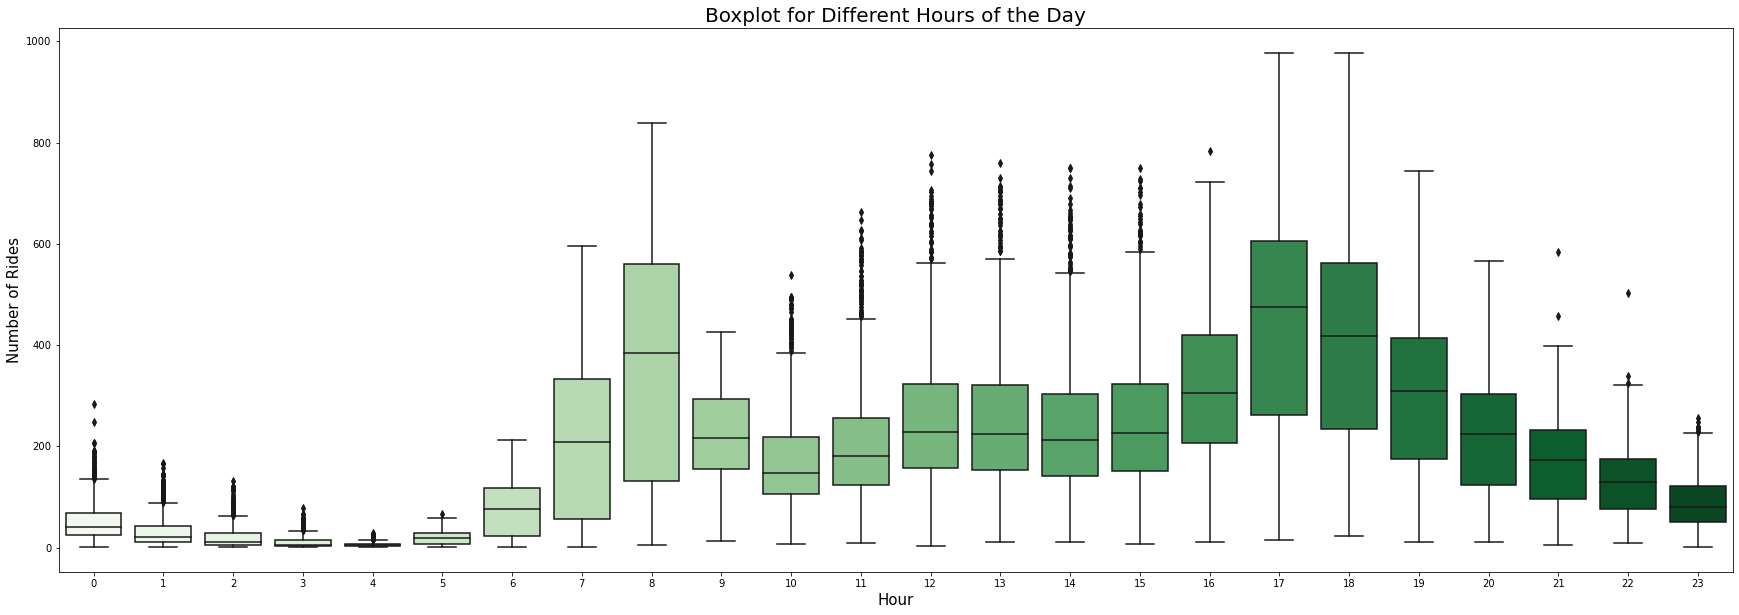

In [13]:
# Total number of passengers by hour of day
fig, (graph1) = plt.subplots(ncols=1, figsize=(30, 10))

sns.boxplot(x = "hour", y = "total_rentals", data=data, palette = "Greens")
graph1.set_title("Boxplot for Different Hours of the Day",fontsize = 20)
graph1.set_xlabel("Hour" , fontsize = 15)
graph1.set_ylabel("Number of Rides" , fontsize = 15)

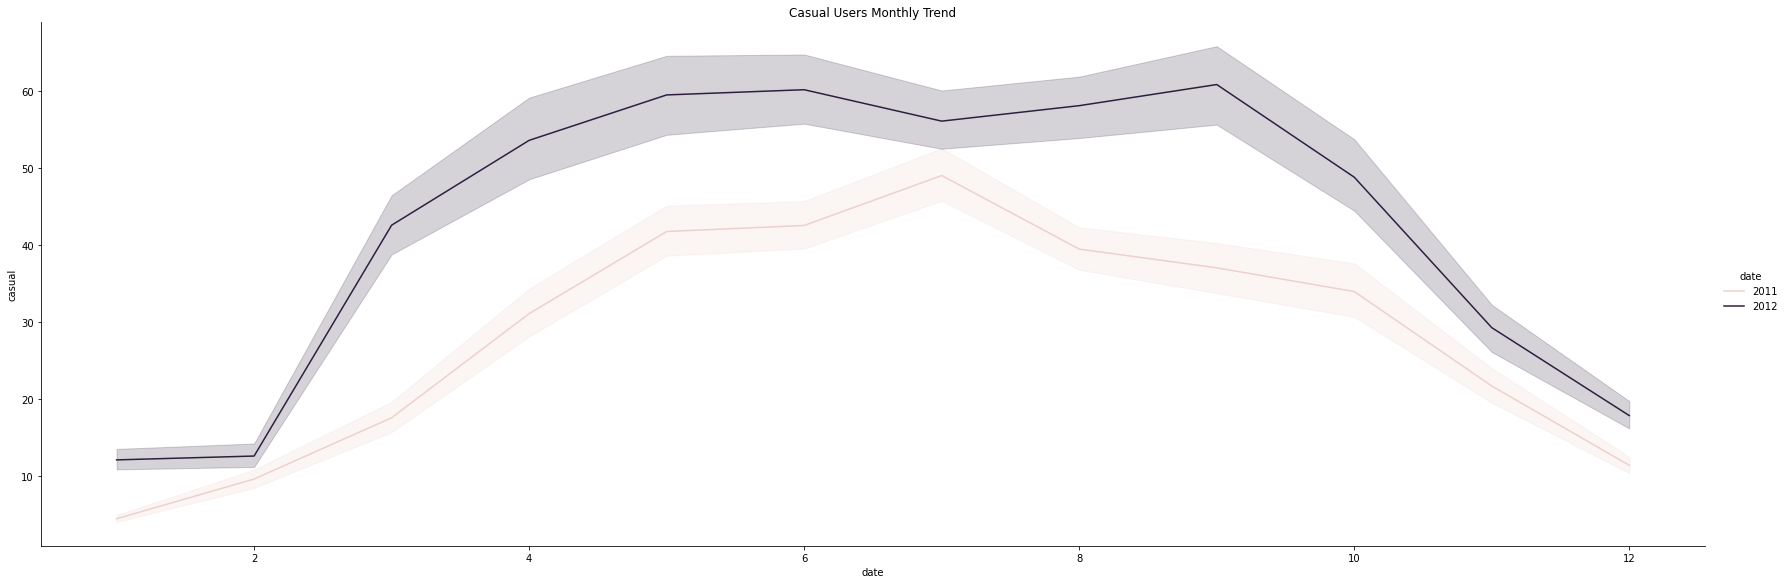

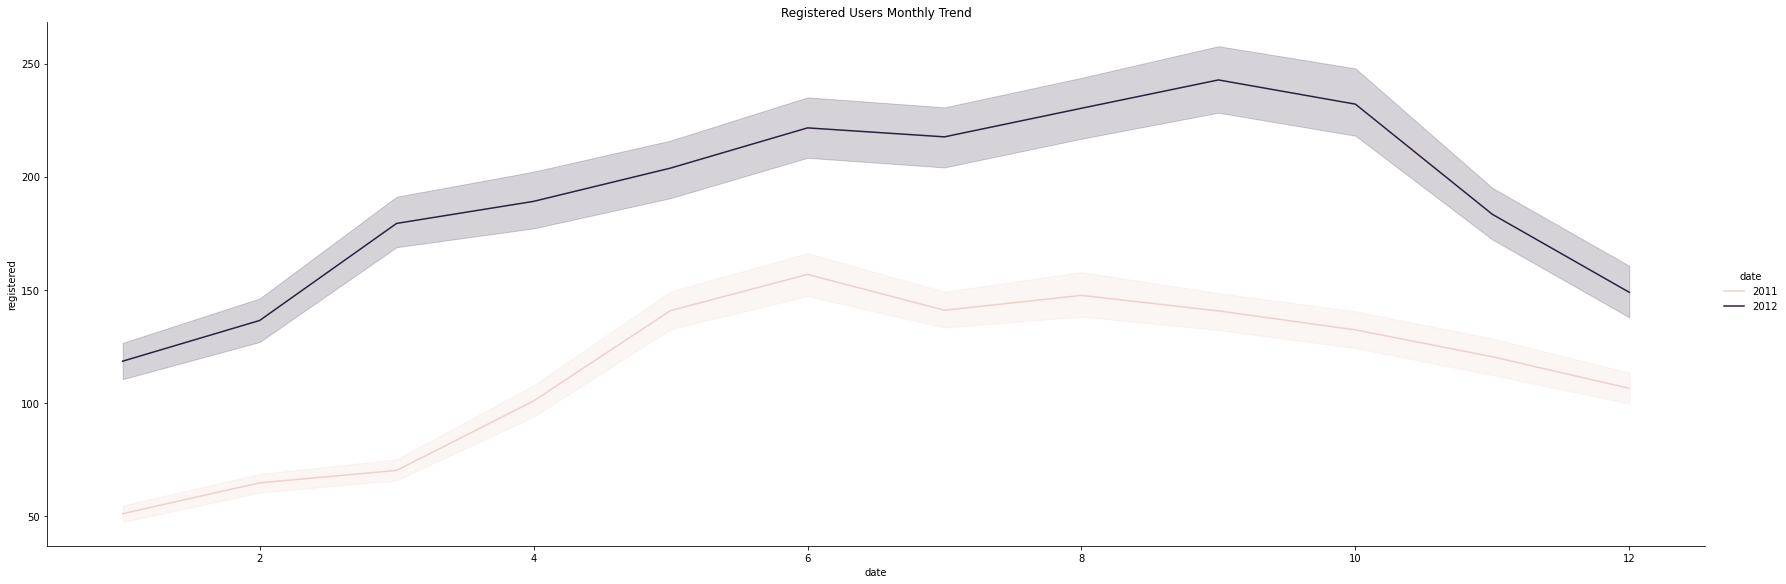

In [14]:
# Casual and Registered Rides Monthly for Different Years
sns.relplot(x=data["date"].dt.month, y="casual", hue=data["date"].dt.year, dashes=False, markers=True, kind="line", height = 8, aspect = 3, data=data).set(title="Casual Users Monthly Trend")
sns.relplot(x=data["date"].dt.month, y="registered", hue=data["date"].dt.year, dashes=False, markers=True, kind="line", height = 8, aspect = 3, data=data).set(title="Registered Users Monthly Trend")

Text(0, 0.5, 'Number of Rides')

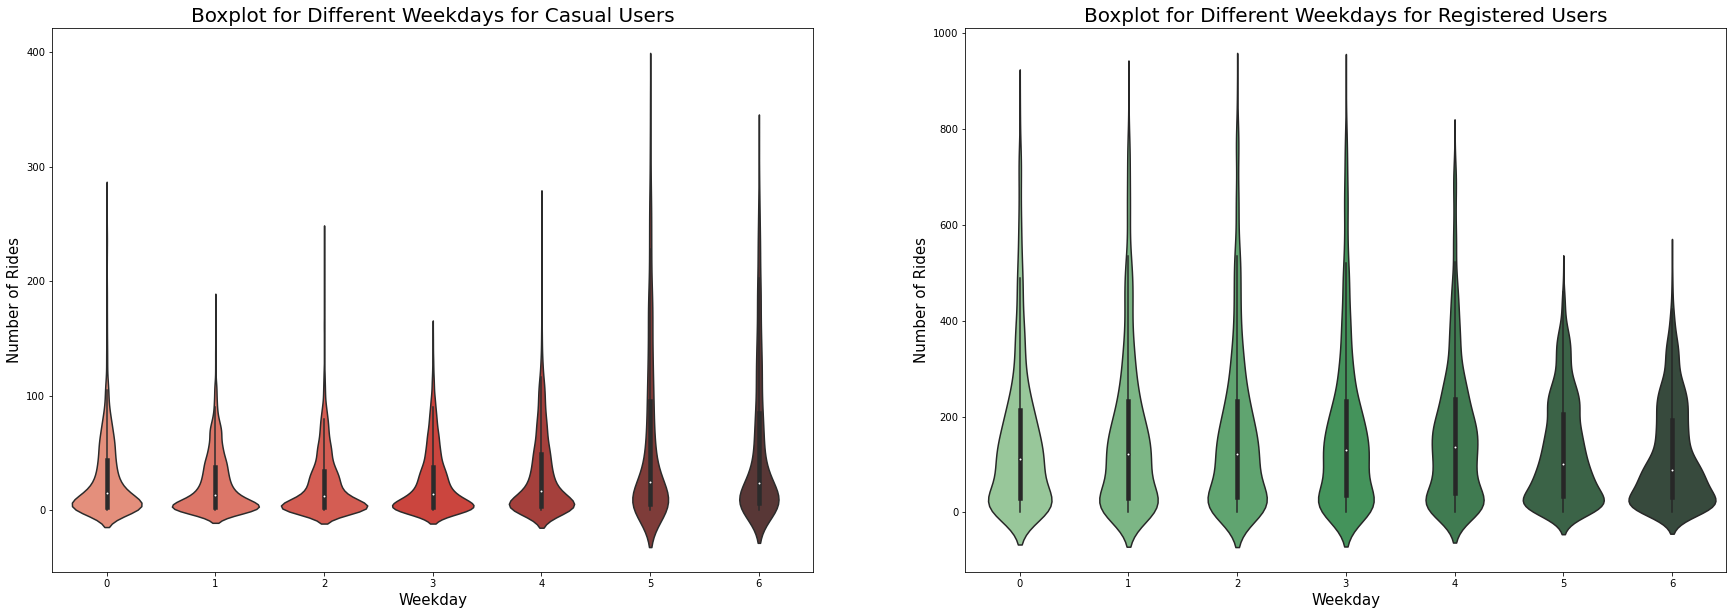

In [15]:
# Total number of passengers by weekday by casual and registered
fig, (graph1, graph2) = plt.subplots(ncols=2, figsize=(30, 10))

sns.violinplot(x=data["date"].dt.weekday, y="casual", data=data, ax=graph1, palette="Reds_d")
graph1.set_title("Boxplot for Different Weekdays for Casual Users",fontsize = 20)
graph1.set_xlabel("Weekday" , fontsize = 15)
graph1.set_ylabel("Number of Rides" , fontsize = 15)

sns.violinplot(x=data["date"].dt.weekday, y="registered", data=data, ax=graph2, palette="Greens_d")
graph2.set_title("Boxplot for Different Weekdays for Registered Users",fontsize = 20)
graph2.set_xlabel("Weekday" , fontsize = 15)
graph2.set_ylabel("Number of Rides" , fontsize = 15)

Text(0, 0.5, 'Number of Rides')

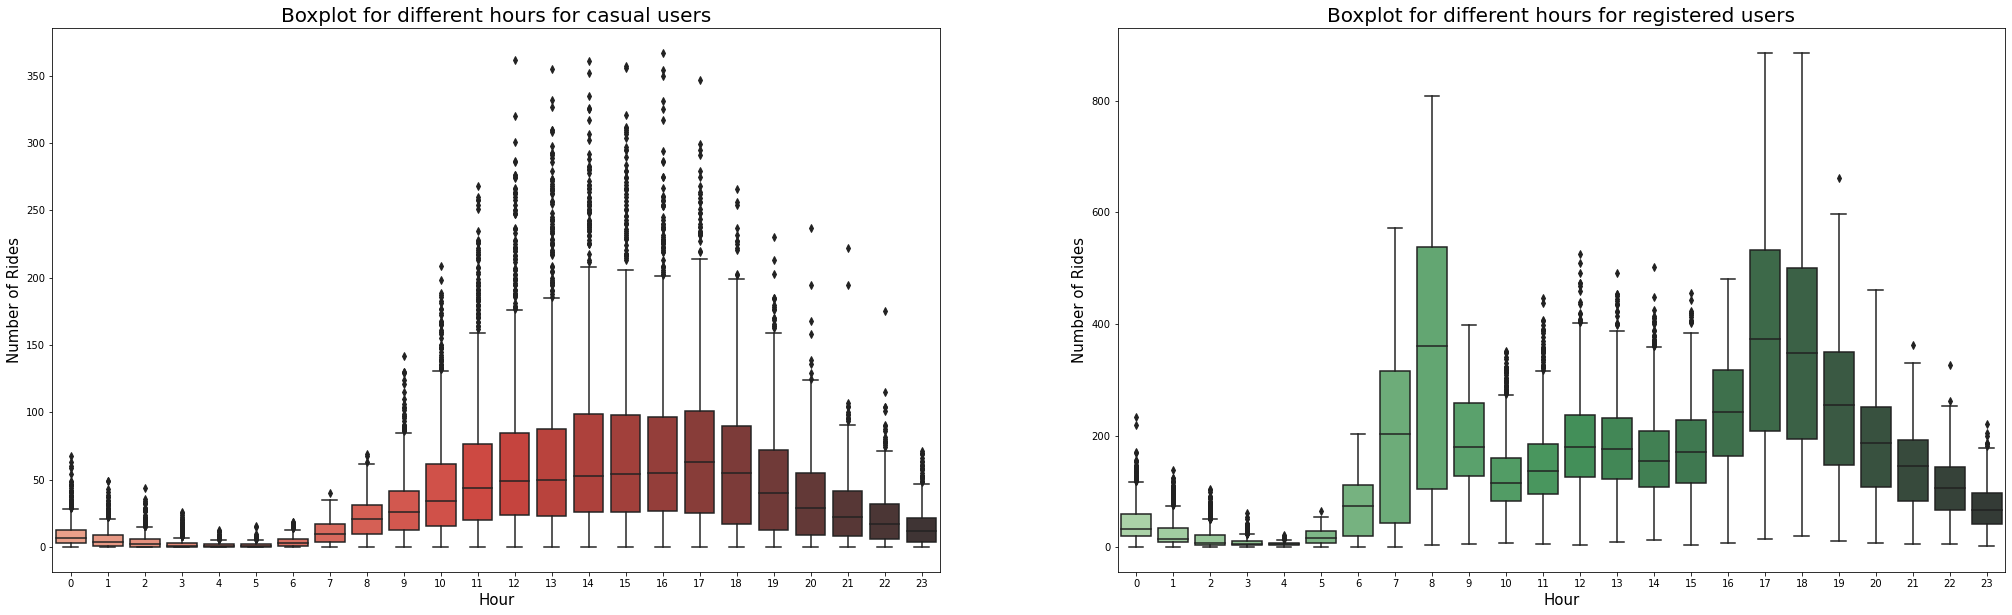

In [16]:
# Total number of passengers by hour of day for casual and registered
fig, (graph1, graph2) = plt.subplots(ncols=2, figsize=(35, 10))

sns.boxplot(x="hour", y="casual", data=data, ax=graph1, palette="Reds_d")
graph1.set_title("Boxplot for different hours for casual users",fontsize = 20)
graph1.set_xlabel("Hour" , fontsize = 15)
graph1.set_ylabel("Number of Rides" , fontsize = 15)

sns.boxplot(x="hour", y="registered", data=data, ax=graph2, palette="Greens_d")
graph2.set_title("Boxplot for different hours for registered users",fontsize = 20)
graph2.set_xlabel("Hour" , fontsize = 15)
graph2.set_ylabel("Number of Rides" , fontsize = 15)

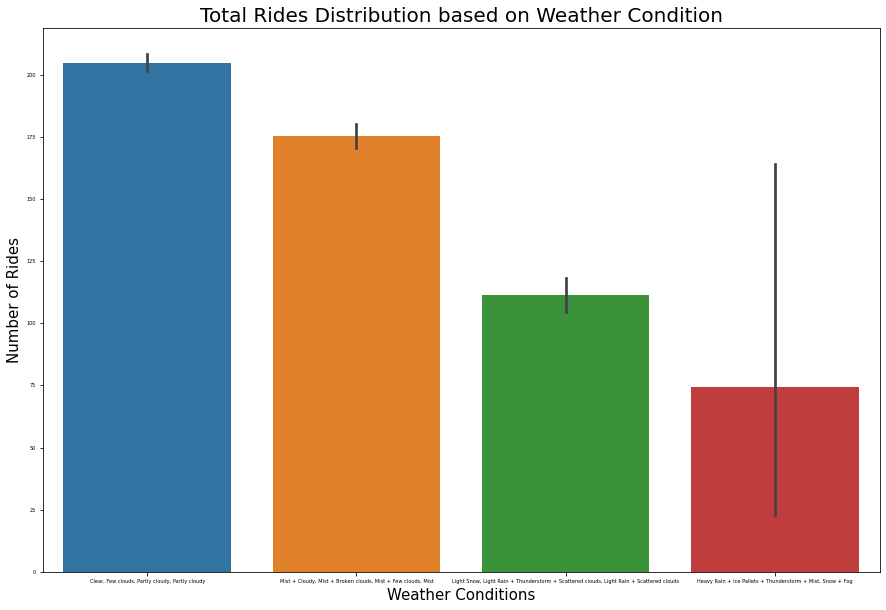

In [17]:
# Total Rides distribution based on Weather condition
fig,ax1=plt.subplots(figsize=(15,10))

#Bar plot for weather_condition distribution of number of rides
sns.barplot(x='weather_condition',y='total_rentals',data=data[['total_rentals','weather_condition']],ax=ax1)
ax1.set_title('Total Rides Distribution based on Weather Condition', fontsize = 20)
ax1.set_xlabel("Weather Conditions" , fontsize = 15)
ax1.set_ylabel("Number of Rides" , fontsize = 15)
ax1.tick_params(axis='both',labelsize=5)
plt.show()

Text(0.5, 1.0, 'Ditribution of aTemperature')

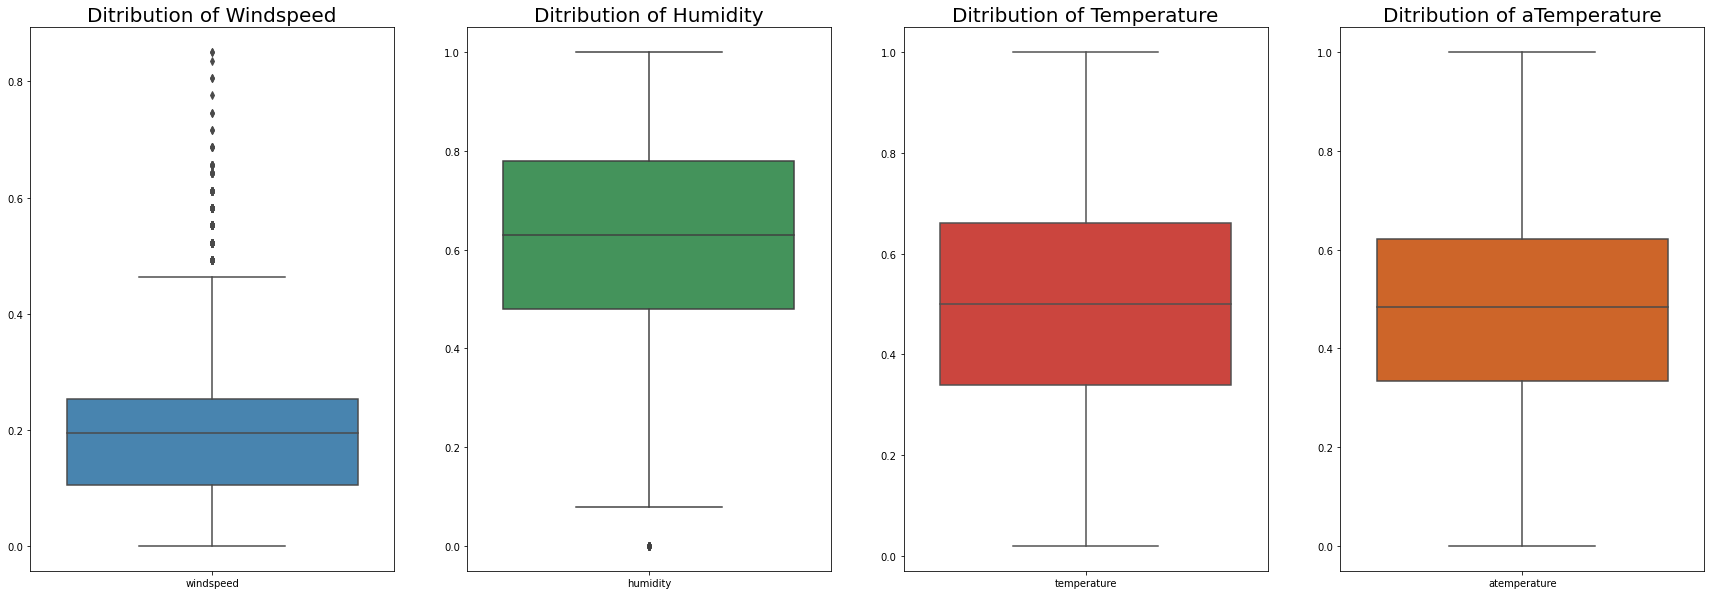

In [18]:
# Handling outliers - only looking at our numerical explanatory variables (weathersit, temp, hum - we already know we will drop atemp later due to corr w/ temp) :

fig, (graph1, graph2, graph3, graph4) = plt.subplots(ncols=4, figsize=(30, 10))

sns.boxplot(data=data[['windspeed']], ax=graph1, palette="Blues_d")
graph1.set_title("Ditribution of Windspeed",fontsize = 20)

sns.boxplot(data=data[['humidity']], ax=graph2, palette="Greens_d")
graph2.set_title("Ditribution of Humidity",fontsize = 20)

sns.boxplot(data=data[['temperature']], ax=graph3, palette="Reds_d")
graph3.set_title("Ditribution of Temperature",fontsize = 20)

sns.boxplot(data=data[['atemperature']], ax=graph4, palette="Oranges_d")
graph4.set_title("Ditribution of aTemperature",fontsize = 20)

Text(0.5, 1.0, 'Boxplot for different hours for casual users')

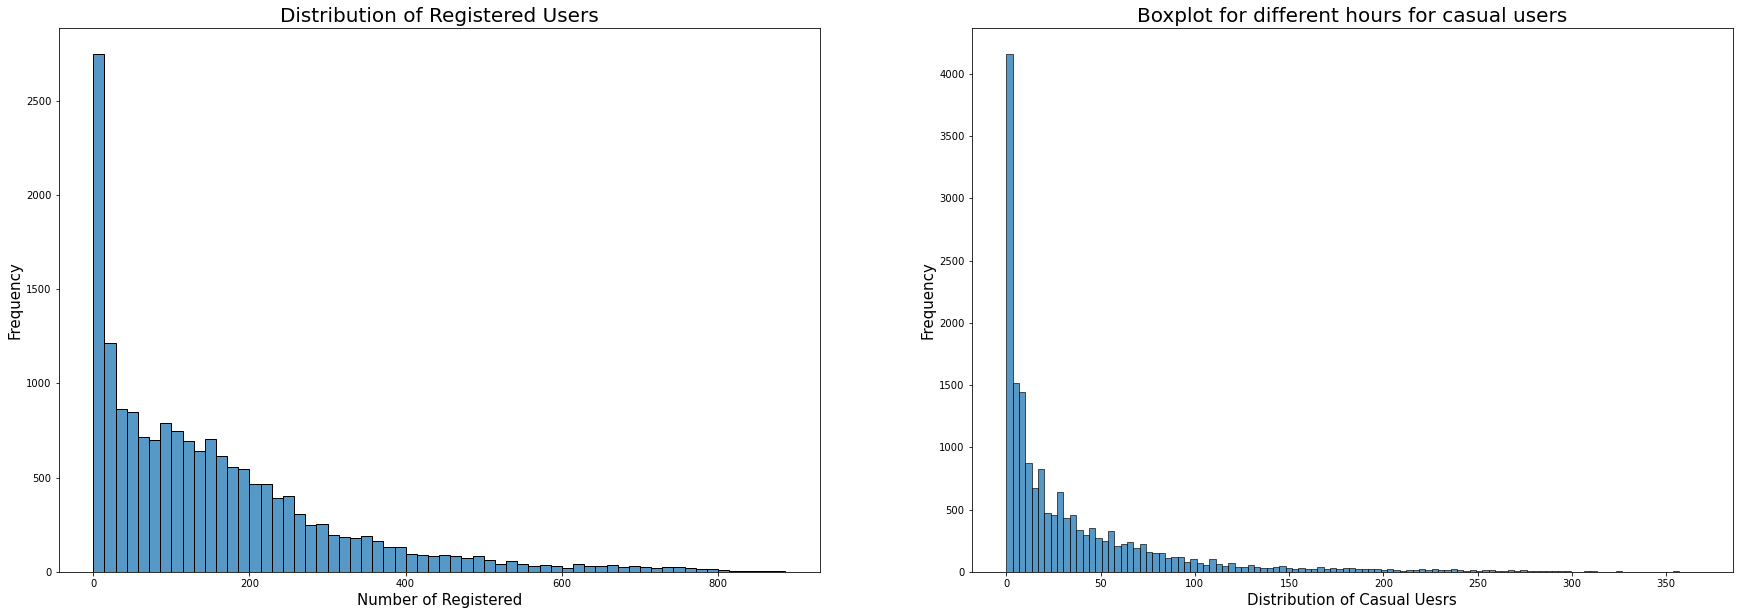

In [19]:
fig, (graph1, graph2) = plt.subplots(ncols=2, figsize=(30, 10))

sns.histplot(data["registered"], ax=graph1)
graph1.set_xlabel("Number of Registered" , fontsize = 15)
graph1.set_ylabel("Frequency" , fontsize = 15)
graph1.set_title("Distribution of Registered Users",fontsize = 20)

sns.histplot(data["casual"], ax=graph2)
graph2.set_xlabel("Distribution of Casual Uesrs" , fontsize = 15)
graph2.set_ylabel("Frequency" , fontsize = 15)
graph2.set_title("Boxplot for different hours for casual users",fontsize = 20)

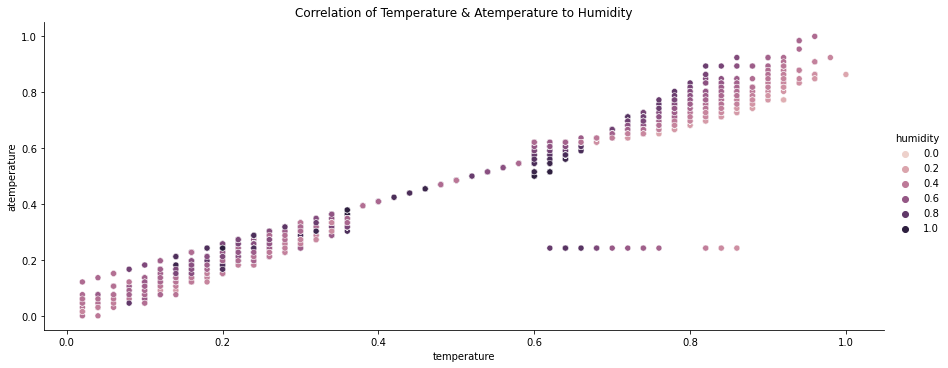

In [20]:
# Different levels of humidity based vs the temperature and atemperature
sns.relplot(
    data=data,
    x="temperature", 
    y="atemperature", 
    hue="humidity",
    height = 5,
    aspect = 2.5).set(title='Correlation of Temperature & Atemperature to Humidity')

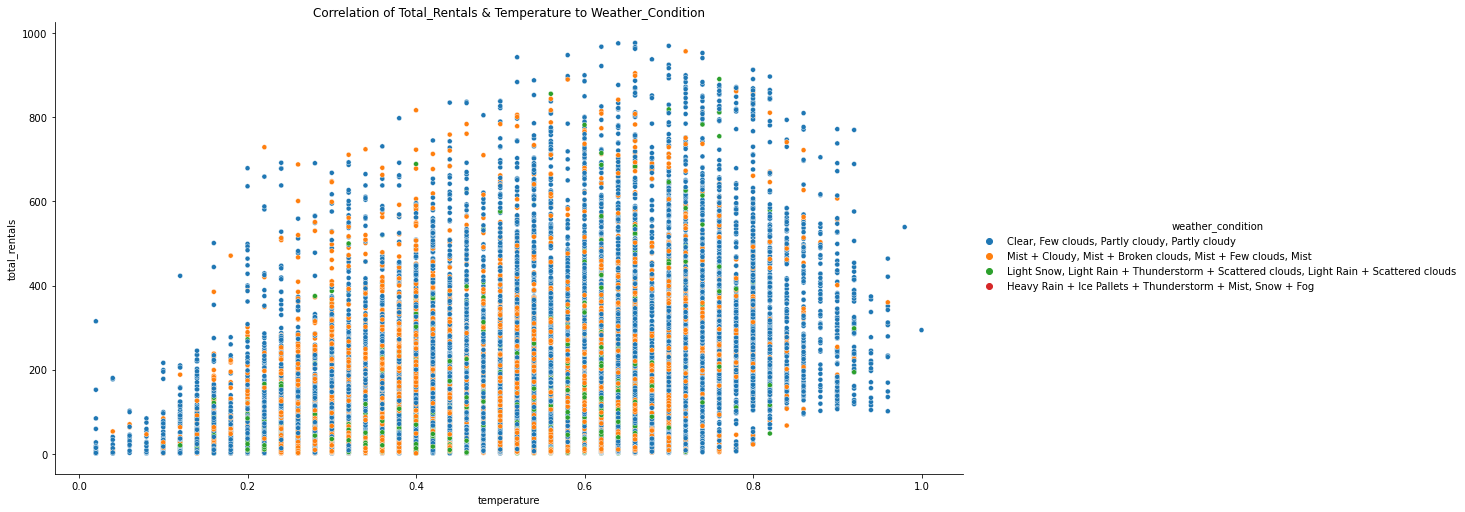

In [21]:
# NOT SURE WHAT THIS IS WE NEEED TO FIND A TITLE FOR IT
sns.relplot(data=data, x="temperature", y="total_rentals", hue="weather_condition", s =25, height = 7, aspect = 2).set(title='Correlation of Total_Rentals & Temperature to Weather_Condition')

## 1.3. Checking possibly redundant variables via correlations

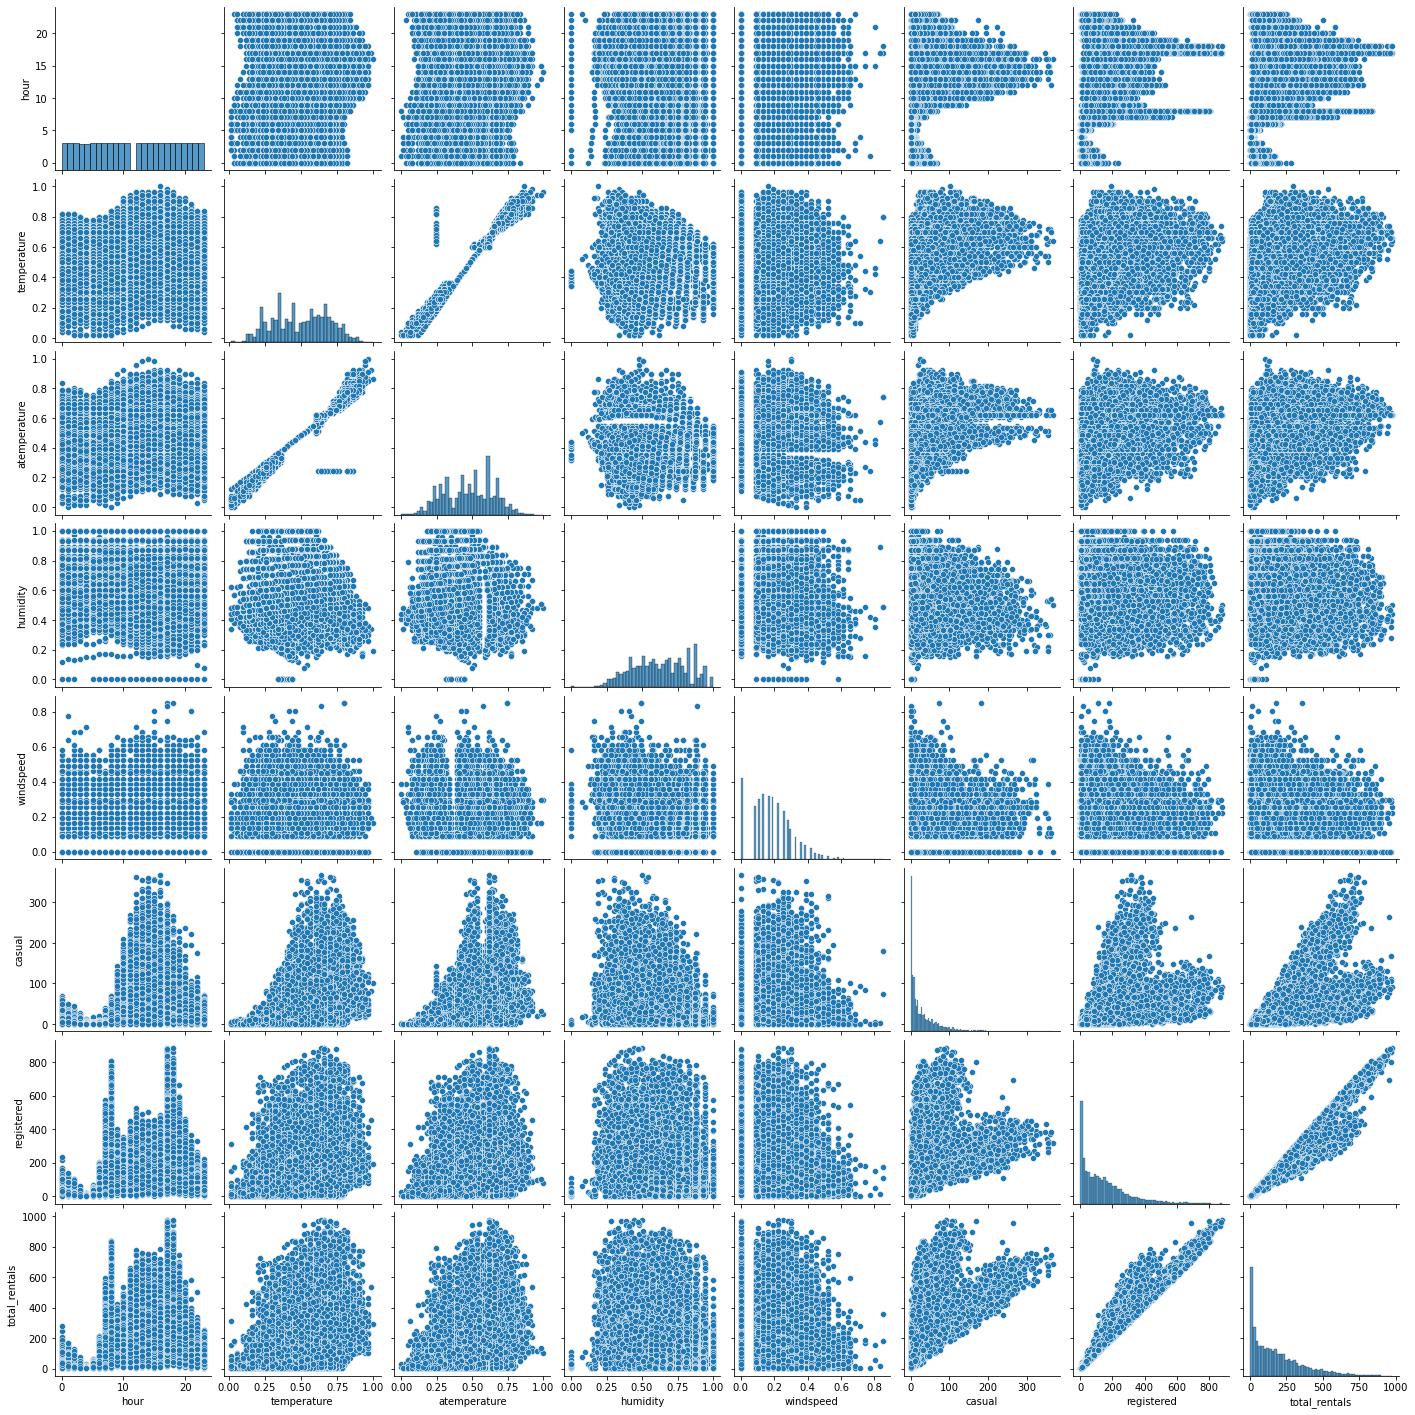

In [22]:
sns.pairplot(data)

In [23]:
data.corr()

,hour,temperature,atemperature,humidity,windspeed,casual,registered,total_rentals
hour,1.000000,0.136511,0.133510,-0.276465,0.137523,0.301202,0.374141,0.394071
temperature,0.136511,1.000000,0.987600,-0.069513,-0.023297,0.459860,0.335735,0.405164
atemperature,0.133510,0.987600,1.000000,-0.052123,-0.062761,0.453949,0.332708,0.401031
humidity,-0.276465,-0.069513,-0.052123,1.000000,-0.289951,-0.346858,-0.274069,-0.323022
windspeed,0.137523,-0.023297,-0.062761,-0.289951,1.000000,0.090390,0.082854,0.093692
casual,0.301202,0.459860,0.453949,-0.346858,0.090390,1.000000,0.506618,0.694564
registered,0.374141,0.335735,0.332708,-0.274069,0.082854,0.506618,1.000000,0.972151
total_rentals,0.394071,0.405164,0.401031,-0.323022,0.093692,0.694564,0.972151,1.000000


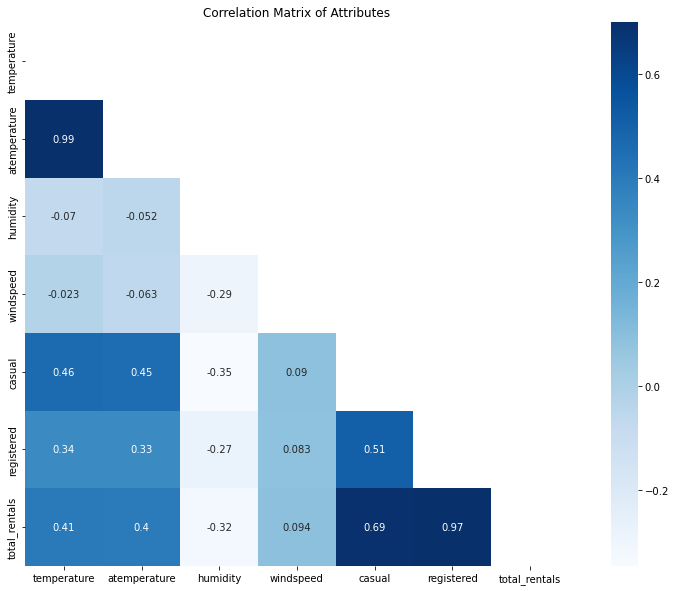

In [24]:
#Create the correlation matrix
features_correlation = data[["temperature","atemperature","humidity","windspeed","casual","registered","total_rentals"]].corr()
mask = np.zeros_like(features_correlation)
mask[np.triu_indices_from(mask)] = True

#Heat map for correlation matrix of attributes
fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(features_correlation, cmap="Blues", annot=True, mask=mask, vmax=.7, square=True)
ax.set_title('Correlation Matrix of Attributes')
plt.show()

In [25]:
data.corr()[["total_rentals"]].sort_values("total_rentals")

,total_rentals
humidity,-0.323022
windspeed,0.093692
hour,0.394071
atemperature,0.401031
temperature,0.405164
casual,0.694564
registered,0.972151
total_rentals,1.000000


## 1.4. Giving insights on what seems relevant for prediction and what does not

There is a high correlation between the following features:
* temperature and atemperature
* registered and total_rentals
* casual and total_rentals

Some of the variables we can ignore when predicting will be:
* atemperature
* casual
* regsitered

# **Part 2: Data Engineering**

## 2.1. Treatment of text and date features

In [26]:
# copying original data in new df for comparison/security
prep_data = data.copy()

In [27]:
# Extract further time-related features
prep_data["day"] = prep_data["date"].dt.day
prep_data["weekday"] = prep_data["date"].dt.weekday
prep_data["week"] = prep_data["date"].dt.isocalendar().week
prep_data["month"] = prep_data["date"].dt.month
prep_data["year"] = prep_data["date"].dt.year

prep_data["weekend"] = prep_data["weekday"].map(lambda x: 1*(x>4))

# hour can be used to create new column for labeling (day/night)
prep_data["day_period"] = pd.cut(
    prep_data["hour"], 
    bins=[0, 6, 12, 18, 24],
    include_lowest=True,
    labels=["night", "morning", "afternoon", "evening"]
)

# season information for labeling - using for loop instead of cut/binning since month 12 & 1 & 2 belong to winter: 
season = []

for month in list(prep_data["month"]):
    if month == 3 or month == 4 or month == 5:
        season.append("spring")
        
    elif month == 6 or month == 7 or month == 8:
        season.append("summer")
        
    elif month == 9 or month == 10 or month == 11:
        season.append("fall")
    
    else:
        season.append("winter")
        
prep_data["season"] = season

prep_data.head()

,date,hour,weather_condition,temperature,atemperature,humidity,windspeed,casual,registered,total_rentals,day,weekday,week,month,year,weekend,day_period,season
record_id,,,,,,,,,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16,1,5,52,1,2011,1,night,winter
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40,1,5,52,1,2011,1,night,winter
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32,1,5,52,1,2011,1,night,winter
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13,1,5,52,1,2011,1,night,winter
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1,1,5,52,1,2011,1,night,winter


In [28]:
data_per_day_period = prep_data.groupby(["day_period"], as_index=False).mean()
data_per_day_period[["day_period","casual","registered","total_rentals"]]

,day_period,casual,registered,total_rentals
0,night,4.457508,27.864227,32.321736
1,morning,39.662847,197.926198,237.589044
2,afternoon,71.990400,252.146743,324.137143
3,evening,30.142308,155.664560,185.806868


In [29]:
# weathersit needs to be looked at further - what transformation makes sense?
# 4 different status for weather sit --> seems to be broader buckets from good weather ----> bad weather 
prep_data.weather_condition.unique()

array(['Clear, Few clouds, Partly cloudy, Partly cloudy',
       'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
       'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
       nan, 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'],
      dtype=object)

In [30]:
# transforming weather_condition from text to category [1-4] while keeping nan:

weather_condition_items = list(prep_data["weather_condition"].unique())
weather_condition = []

for item in list(prep_data["weather_condition"]):
    if item == weather_condition_items[0]:
        weather_condition.append("1")
        
    elif item == weather_condition_items[1]:
        weather_condition.append("2")
        
    elif item == weather_condition_items[2]:
        weather_condition.append("3")
        
    elif item == weather_condition_items[-1]:
        weather_condition.append("4")
        
    else:
        weather_condition.append(None)

        
prep_data["weather_condition"] = weather_condition

## 2.2. Generation of extra features and studying the influence of combinations of features

In [31]:
prep_data['dew_point'] = data.humidity**(1/8) * (112+0.9*data.temperature) + 0.1*data.temperature - 112
prep_data['mean_temperature_humidity'] = ( data.temperature + data.humidity ) / 2
prep_data['mean_temperature_windspeed'] = ( data.temperature + data.windspeed ) / 2
prep_data['mean_humidity_windspeed'] = ( data.humidity + data.windspeed ) / 2
prep_data['mean_humidity_windspeed_temperature'] = ( data.humidity + data.windspeed + data.temperature) / 3

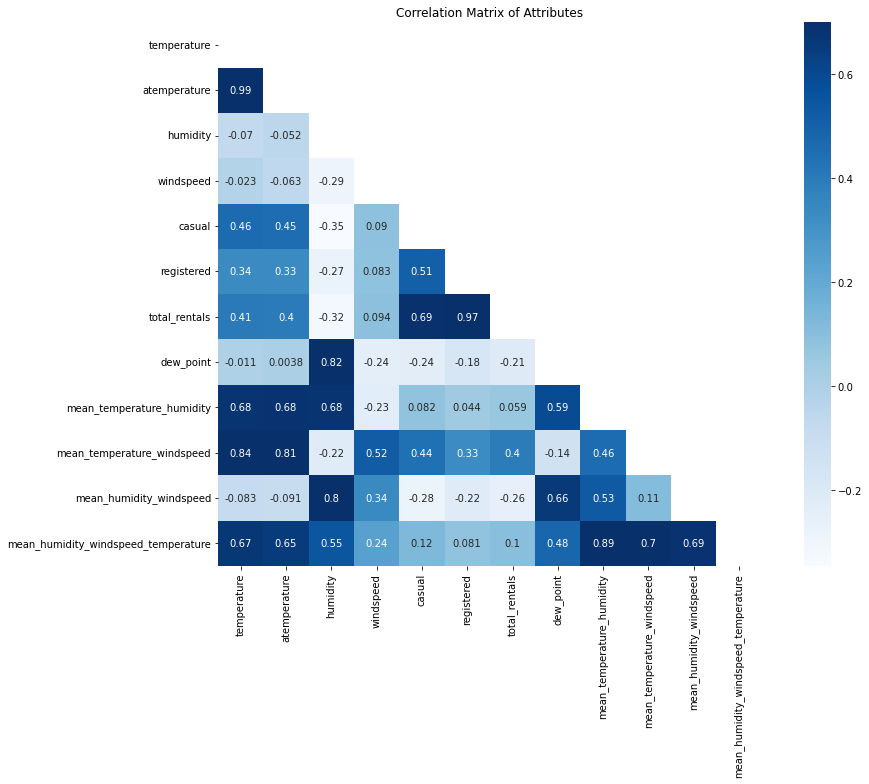

In [32]:
#Create the correlation matrix
features_correlation_2 = prep_data[["temperature","atemperature","humidity","windspeed","casual","registered","total_rentals", 'dew_point', 'mean_temperature_humidity', 'mean_temperature_windspeed', 'mean_humidity_windspeed','mean_humidity_windspeed_temperature']].corr()
mask = np.zeros_like(features_correlation_2)
mask[np.triu_indices_from(mask)] = True

#Heat map for correlation matrix of attributes
fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(features_correlation_2, cmap="Blues", annot=True, mask=mask, vmax=.7, square=True)
ax.set_title('Correlation Matrix of Attributes')
plt.show()

## 2.3. Giving new insights on what seems relevant for prediction and what does not

In [33]:
prep_data.columns

Index(['date', 'hour', 'weather_condition', 'temperature', 'atemperature',
       'humidity', 'windspeed', 'casual', 'registered', 'total_rentals', 'day',
       'weekday', 'week', 'month', 'year', 'weekend', 'day_period', 'season',
       'dew_point', 'mean_temperature_humidity', 'mean_temperature_windspeed',
       'mean_humidity_windspeed', 'mean_humidity_windspeed_temperature'],
      dtype='object')

In [34]:
# Time to seperate our dataset into explanatory features and target features
# Since registered and casual users columns are parts of our target cnt we remove them from the dataset 
# We also drop atemp since it is highly correlated with temp (0.99 - see heatmap above), thus, containing same info
# We will also drop the new features we crated since they didn't seem to have any correlation to the rest of the variables
# instant is glorified index so can be dropped as well

x = prep_data.copy().drop(["total_rentals","casual","registered","atemperature", 'dew_point', 'mean_temperature_humidity', 'mean_temperature_windspeed', 'mean_humidity_windspeed','mean_humidity_windspeed_temperature'], axis=1)
y = prep_data.loc[:, "total_rentals"]

In [35]:
x.head()

,date,hour,weather_condition,temperature,humidity,windspeed,day,weekday,week,month,year,weekend,day_period,season
record_id,,,,,,,,,,,,,,
1,2011-01-01,0,1,0.24,0.81,0.0,1,5,52,1,2011,1,night,winter
2,2011-01-01,1,1,0.22,0.80,0.0,1,5,52,1,2011,1,night,winter
3,2011-01-01,2,1,0.22,0.80,0.0,1,5,52,1,2011,1,night,winter
4,2011-01-01,3,1,0.24,0.75,0.0,1,5,52,1,2011,1,night,winter
5,2011-01-01,4,1,0.24,0.75,0.0,1,5,52,1,2011,1,night,winter


In [36]:
y.head()

record_id
1    16
2    40
3    32
4    13
5     1
Name: total_rentals, dtype: int64

## 2.4. Discussion on missing values and outliers

In [37]:
# for better data handling we already implement split for train & test data so to just handle outliers in train set
# Requirement: training set to be whole 2011 & first 3 qs of 2012 & 
# Test date being 4th q of 2012 --> defining this manually here instead of using train_test_split from sklearn

x_train = x[x["date"]<"2012-10-01"] 
x_test = x[x["date"]>="2012-10-01"]
y_train = y.iloc[0:len(x_train)]
y_test = y.iloc[len(x_train):]

In [38]:
### IQR Outlier Capping Method:

outlier_df = x_train.describe()

def outlier_function(df, col_name):
    first_quartile = outlier_df[col_name][4]
    third_quartile = outlier_df[col_name][6]
    IQR = third_quartile - first_quartile
    upper_limit = third_quartile+(1.5*IQR)
    lower_limit = first_quartile-(1.5*IQR)
    #Counting
    outlier_count = len(df[(df[col_name]>upper_limit) | (df[col_name]<lower_limit)])
    return lower_limit, upper_limit, outlier_count


In [39]:
numeric = ["windspeed", "temperature", "humidity"]
dic_outliers = {}
for column in numeric:
        print("There are {} outliers in {}".format(outlier_function(x_train, column)[2], column))
        dic_outliers[column] = outlier_function(x_train, column)[:2]


There are 307 outliers in windspeed
There are 0 outliers in temperature
There are 22 outliers in humidity


In [40]:
action = "clip" #choose between clip, drop or nothing
for cols,limits in dic_outliers.items():
    if action == 'drop':
        data = x_train[(x_train[cols]<=limits[1]) & (x_train[cols]>=limits[0])].reset_index()
        data = x_train.drop(columns = ['index'])
    elif action == 'clip':
        x_train.loc[x_train[cols]>limits[1],cols] = limits[1]
        x_train.loc[x_train[cols]<limits[0],cols] = limits[0]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Text(0.5, 1.0, 'Distribution of Temperature')

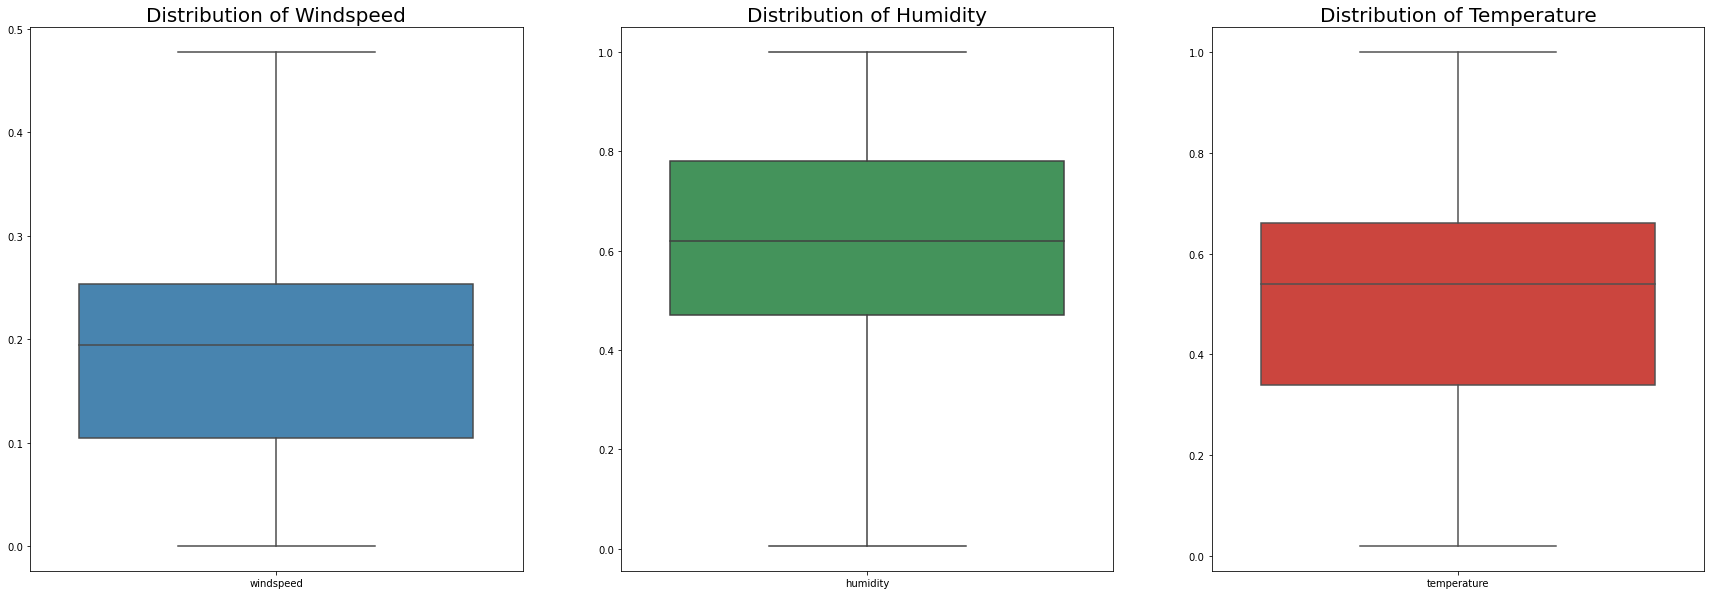

In [41]:
# Handling outliers - only looking at our numerical explanatory variables (weathersit, temp, hum - we already know we will drop atemp later due to corr w/ temp) :

fig, (graph1, graph2, graph3) = plt.subplots(ncols=3, figsize=(30, 10))

sns.boxplot(data=x_train[['windspeed']], ax=graph1, palette="Blues_d")
graph1.set_title("Distribution of Windspeed",fontsize = 20)

sns.boxplot(data=x_train[['humidity']], ax=graph2, palette="Greens_d")
graph2.set_title("Distribution of Humidity",fontsize = 20)

sns.boxplot(data=x_train[['temperature']], ax=graph3, palette="Reds_d")
graph3.set_title("Distribution of Temperature",fontsize = 20)

## 2.5. Use of scikit-learn pipelines to perform transformations

In [42]:
x_train.dtypes

date                 datetime64[ns]
hour                          int64
weather_condition            object
temperature                 float64
humidity                    float64
windspeed                   float64
day                           int64
weekday                       int64
week                         UInt32
month                         int64
year                          int64
weekend                       int64
day_period                 category
season                       object
dtype: object

In [43]:
# casting weathersit as category so that we can handle them latter in our transform pipeline
# same for week - needs to be int64 and not UINT32 --> better to do it as category
# season needs to be casted as category as well
# as well for all time features as categories

categorical_cols = ["day_period", "weekend", "season"]

for col in categorical_cols:
    x_train[col] = x_train[col].astype("category")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [44]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15211 entries, 1 to 15211
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               15211 non-null  datetime64[ns]
 1   hour               15211 non-null  int64         
 2   weather_condition  15125 non-null  object        
 3   temperature        15122 non-null  float64       
 4   humidity           15122 non-null  float64       
 5   windspeed          15123 non-null  float64       
 6   day                15211 non-null  int64         
 7   weekday            15211 non-null  int64         
 8   week               15211 non-null  UInt32        
 9   month              15211 non-null  int64         
 10  year               15211 non-null  int64         
 11  weekend            15211 non-null  category      
 12  day_period         15211 non-null  category      
 13  season             15211 non-null  category      
dtypes: UIn

In [45]:
# what about nans?
x_train.isna().sum()

date                  0
hour                  0
weather_condition    86
temperature          89
humidity             89
windspeed            88
day                   0
weekday               0
week                  0
month                 0
year                  0
weekend               0
day_period            0
season                0
dtype: int64

In [46]:
# Some missing values for 4 explanatory variables - will be handled in our transform pipeline to get ready for ML model 
# let's first separate features

categorical_features = ["day_period", 'weekend','season']
numerical_features = ["temperature","humidity","windspeed", "week", 'year', 'month', 'day', 'hour', 'weekday', "weather_condition"]

In [47]:
# Define categorical pipeline

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

# Define numerical pipeline
numerical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler()) #temp, hum, windspeed already looked scaled so guess not needed here
])

# Fit column transformer to training data
preprocessor = ColumnTransformer(
    transformers = [
    ("categorical", categorical_pipe, categorical_features),
    ("numerical", numerical_pipe, numerical_features)
])

preprocessor.fit(x_train)

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['day_period', 'weekend', 'season']),
                                ('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['temperature', 'humidity', 'windspeed',
                                  'week', 'year', 'month', 'day', 'hour',
                                  'weekday', 'weather_condition'])])

In [48]:
x_preprocessed = preprocessor.transform(x_train)

x_preprocessed.shape 

(15211, 20)

In [49]:
x_preprocessed.size

304220

In [50]:
t = pd.DataFrame(x_preprocessed)

t.isna().sum().sum()

0

### SOME COMMENTS
* was it correct to put all time features as categories? --> all time features should be numerical!
* better to use forward fill instead of most_frequent / median? problem of using ffill in pipeline --> Juan might look into this
* --> pipeline needs fit transform method - ffill doesn't work like this - way to work around this? Dani wants to see pipeline 
* we think ffill might be interesting since for nans in hum,temp, windspeed we guess it makes more sense that these values are close/the same
* as previous values since it will be the same day but just one hour later 

# **Part 3: Machine Learning**

## 3.1. Choosing sensible models (linear and non-linear)

###         3.1.a - Baseline Linear Regression with Initial Variables

In [51]:
# preping df with original data only including explanatory initial variables
x_baseline = data.copy()
x_baseline = x_baseline.fillna(method="ffill")
x_baseline = x_baseline.drop(["casual","registered","total_rentals"], axis=1)

In [52]:
x_baseline.isna().sum()

date                 0
hour                 0
weather_condition    0
temperature          0
atemperature         0
humidity             0
windspeed            0
dtype: int64

In [53]:
# transforming weather_condition from text to category [1-4] while keeping nan:

weather_condition_items = list(x_baseline["weather_condition"].unique())
weather_condition = []

for item in list(x_baseline["weather_condition"]):
    if item == weather_condition_items[0]:
        weather_condition.append("1")
        
    elif item == weather_condition_items[1]:
        weather_condition.append("2")
        
    elif item == weather_condition_items[2]:
        weather_condition.append("3")
        
    elif item == weather_condition_items[-1]:
        weather_condition.append("4")
        
    else:
        weather_condition.append(None)

        
x_baseline["weather_condition"] = weather_condition

In [54]:
x_train_baseline = x_baseline[x_baseline["date"]<"2012-10-01"] 
x_test_baseline = x_baseline[x_baseline["date"]>="2012-10-01"]
y_train_baseline = y.iloc[0:len(x_train)]
y_test_baseline = y.iloc[len(x_train):]

In [55]:
# using this simple method to fill nans instead of pipeline transformers to test simple baseline model performance
x_train_baseline = x_train_baseline.fillna(method="ffill")
x_test_baseline = x_test_baseline.fillna(method="ffill")

In [56]:
x_test_baseline.isna().sum()

date                 0
hour                 0
weather_condition    0
temperature          0
atemperature         0
humidity             0
windspeed            0
dtype: int64

In [57]:
# scaling hour & weather_condition with minmaxscaler 

cols_to_scale = ["hour"]

min_max_scaler = ColumnTransformer(
    [
        (
            "min_max_scaler", 
            MinMaxScaler(), 
            cols_to_scale
        )
    ], 
    remainder="drop"
)

scaled_columns = pd.DataFrame(
    min_max_scaler.fit_transform(x_baseline),
    columns=cols_to_scale
)

x_baseline[cols_to_scale] = scaled_columns

In [58]:
# drop date since can't be processed by algorithms
x_train_baseline = x_train_baseline.drop("date", axis=1)
x_test_baseline = x_test_baseline.drop("date", axis=1)

In [59]:
# Baseline Linear Regression Model with Initial Variables 

reg_dict = {
    "LinReg": {
        "algorithm": LinearRegression(),
        },
    "Ridge": {
        "algorithm": Ridge(),
    },
    "Lasso": {
        "algorithm": Lasso(),
    },
    "ElasticNet": {
        "algorithm": ElasticNet(l1_ratio=0.9, max_iter=3000),
    }
}

for algo, algo_dict in reg_dict.items():
    reg = algo_dict["algorithm"].fit(x_train_baseline, y_train_baseline)
    algo_dict["weights"] = reg.coef_ 
    algo_dict["intercept"] = reg.intercept_ 
    algo_dict["train_predictions"] = reg.predict(x_train_baseline)
    algo_dict["train_residuals"] = y_train_baseline - algo_dict["train_predictions"]
    algo_dict["train_r2_score"] = r2_score(y_train_baseline, algo_dict["train_predictions"])
    algo_dict["predictions"] = reg.predict(x_test_baseline)
    algo_dict["residuals"] = y_test_baseline - algo_dict["predictions"]
    algo_dict["mse"] = mean_squared_error(y_test_baseline, algo_dict["predictions"])
    algo_dict["r2_score"] = r2_score(y_test_baseline, algo_dict["predictions"])

In [60]:
# let's have a look at our performance 
algos = ["LinReg","Ridge","Lasso","ElasticNet"]
for algo in algos:
    a = round(reg_dict[algo]["train_r2_score"],2)
    b = round(reg_dict[algo]["r2_score"],2)
    print(f"{algo} with R2-Score on train-data: {a} & R2-Score on test-data: {b}")

LinReg with R2-Score on train-data: 0.35 & R2-Score on test-data: 0.14
Ridge with R2-Score on train-data: 0.35 & R2-Score on test-data: 0.14
Lasso with R2-Score on train-data: 0.35 & R2-Score on test-data: 0.14
ElasticNet with R2-Score on train-data: 0.27 & R2-Score on test-data: 0.14


Text(0.5, 1.0, 'linear')

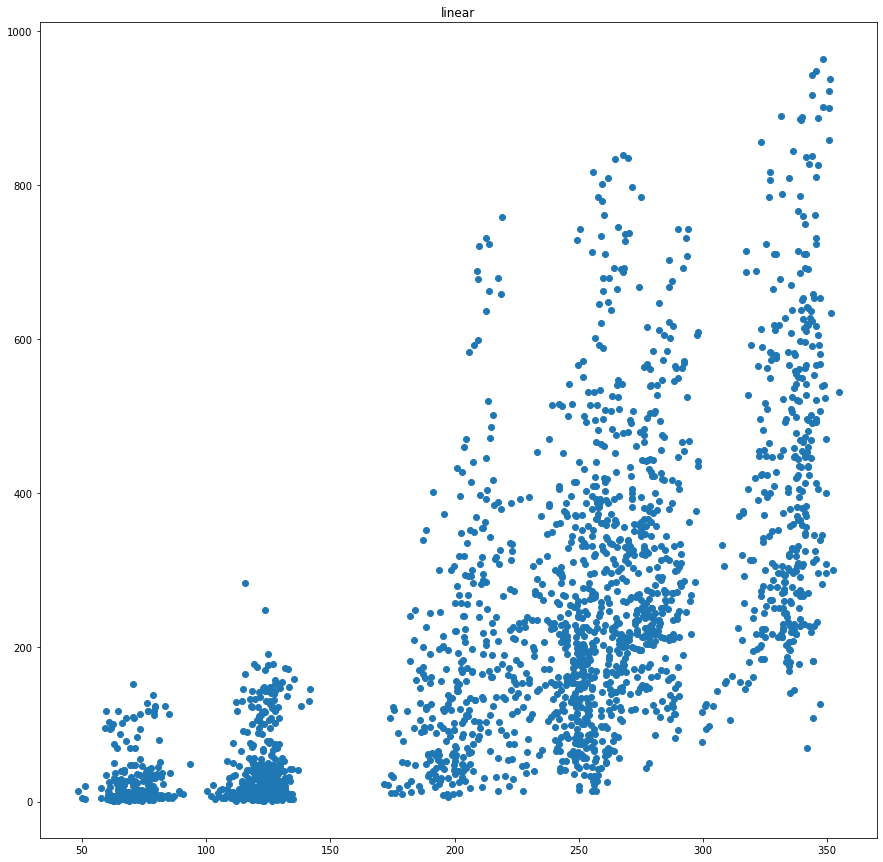

In [80]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(algo_dict["predictions"], y_test)
ax.set_title("linear")

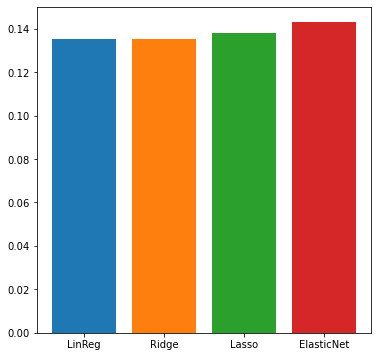

In [61]:
fig, ax = plt.subplots(figsize = (6,6))

for algo, algo_dict in reg_dict.items():
    ax.bar(algo, algo_dict["r2_score"], label = algo)
    ax.legend

#### Doesn't look too good so far!

###         3.1.b - Linear Regression with New Variables


In [63]:
# now we go again but using our pipe-object in the for-loop to fill our lin-regression models dictionary with results
# using train & test split that was set up at the end of feature engineering step:
reg_dict_2 = {
    "LinReg": {
        "algorithm": LinearRegression(),
        },
    "Ridge": {
        "algorithm": Ridge(),
    },
    "Lasso": {
        "algorithm": Lasso(),
    },
    "ElasticNet": {
        "algorithm": ElasticNet(l1_ratio=0.9, max_iter=3000),
    }
}

for algo, algo_dict in reg_dict_2.items():
    pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", algo_dict["algorithm"])])
    pipe.fit(x_train, y_train)
    algo_dict["train_predictions"] = pipe.predict(x_train)
    algo_dict["train_residuals"] = y_train - algo_dict["train_predictions"]
    algo_dict["train_r2_score"] = r2_score(y_train, algo_dict["train_predictions"])
    algo_dict["weights"] = reg.coef_
    algo_dict["intercept"] = reg.intercept_
    algo_dict["predictions"] = pipe.predict(x_test)
    algo_dict["residuals"] = y_test - algo_dict["predictions"]
    algo_dict["mse"] = mean_squared_error(y_test, algo_dict["predictions"])
    algo_dict["r2_score"] = r2_score(y_test, algo_dict["predictions"])

In [64]:
# let's have a look at our performance 
algos = ["LinReg","Ridge","Lasso","ElasticNet"]
for algo in algos:
    a = round(reg_dict_2[algo]["train_r2_score"],2)
    b = round(reg_dict_2[algo]["r2_score"],2)
    print(f"{algo} with R2-Score on train-data: {a} & R2-Score on test-data: {b}")

LinReg with R2-Score on train-data: 0.55 & R2-Score on test-data: 0.49
Ridge with R2-Score on train-data: 0.55 & R2-Score on test-data: 0.49
Lasso with R2-Score on train-data: 0.55 & R2-Score on test-data: 0.48
ElasticNet with R2-Score on train-data: 0.49 & R2-Score on test-data: 0.4


In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(algo_dict[“predictions”], y_test)
ax.set_title(“linear”)

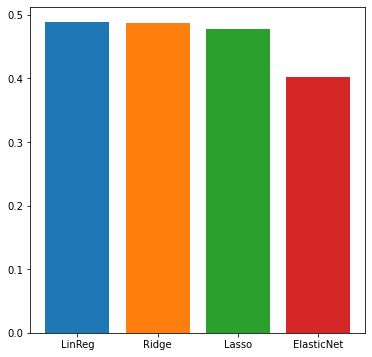

In [65]:
fig, ax = plt.subplots(figsize = (6,6))

for algo, algo_dict in reg_dict_2.items():
    ax.bar(algo, algo_dict["r2_score"], label = algo)
    ax.legend

#### We improved the model a lot already!

###         3.1.c - Baseline Random Forest

In [66]:
# Let's see what happens with a random forest regressor model
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("rf", RandomForestRegressor(random_state=42))
    ]
)

In [67]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['day_period', 'weekend',
                                                   'season']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                  

In [68]:
# predict on x_test
y_hat = pipe.predict(x_test)

r2 = r2_score(y_test, y_hat)
print(r2) 

0.826784374076574


#### Random forests are pretty strong out-of-the-box and using our preprocessor! Let's see if we can improve even further

## 3.2. Tuning model parameters with validation

In [69]:
# let's do a gridsearch and check for the best parameters: 


param_grid = {
    "rf__n_estimators": [150,200,300], 
    "rf__max_features": [0.8, 0.9],
    "rf__max_depth": [None],
    "rf__min_samples_split": [2,5,10],
    "rf__min_samples_leaf": [1,5,10],
}

grid = GridSearchCV(
    pipe,
    param_grid,
    scoring="r2",
    cv=3,
    n_jobs=-1, 
    verbose=1
)

grid.fit(x_train, y_train)
grid.best_score_, grid.best_params_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


(0.7010954128815147,
 {'rf__max_depth': None,
  'rf__max_features': 0.8,
  'rf__min_samples_leaf': 1,
  'rf__min_samples_split': 5,
  'rf__n_estimators': 150})

In [70]:
# trying a "single" rf with best parameters found in gridsearch and predicting on test

grid_best_params = grid.best_params_

pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("rf", RandomForestRegressor(n_estimators=grid_best_params["rf__n_estimators"],
                                     max_depth =grid_best_params["rf__max_depth"],
                                     min_samples_split = grid_best_params["rf__min_samples_split"],
                                     min_samples_leaf=grid_best_params["rf__min_samples_leaf"],
                                     max_features=grid_best_params["rf__max_features"],
                                     random_state=42))
    ]
)

pipe.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['day_period', 'weekend',
                                                   'season']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                  

## 3.3. Obtaining accurate predictions in test

In [71]:
# predict on x_test
y_hat = pipe.predict(x_test)

r2 = r2_score(y_test, y_hat)
print(r2) 

0.837520425304551


## 3.4. Plotting predictions vs reality for additional insights

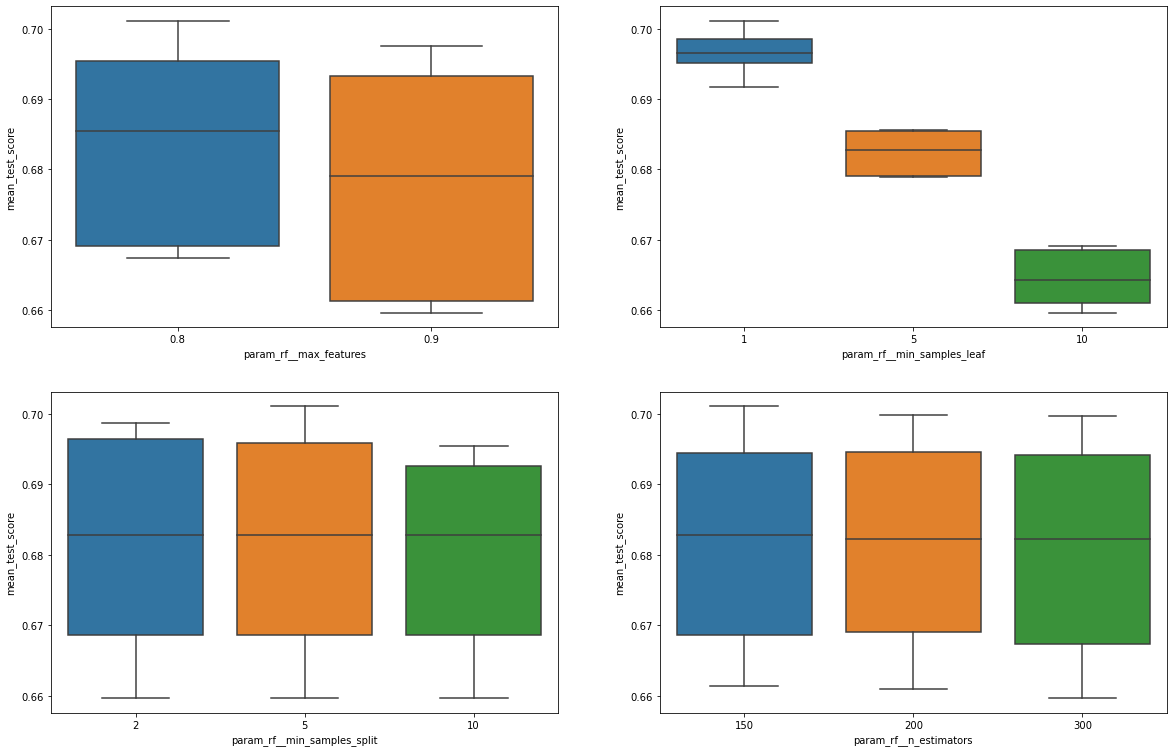

In [77]:
import seaborn as sns

results = pd.DataFrame(grid.cv_results_)
results.head()

best_par = ["param_rf__max_features", "param_rf__min_samples_leaf", "param_rf__min_samples_split", "param_rf__n_estimators"]
fig, axes = plt.subplots(2,2, figsize = (20, 13))
for par, ax in zip (best_par, axes.ravel()):
    
    sns.boxplot(x= results[par], y = results["mean_test_score"], ax=ax)

Text(0.5, 1.0, 'Scatter Plot Real values versus Predicted values')

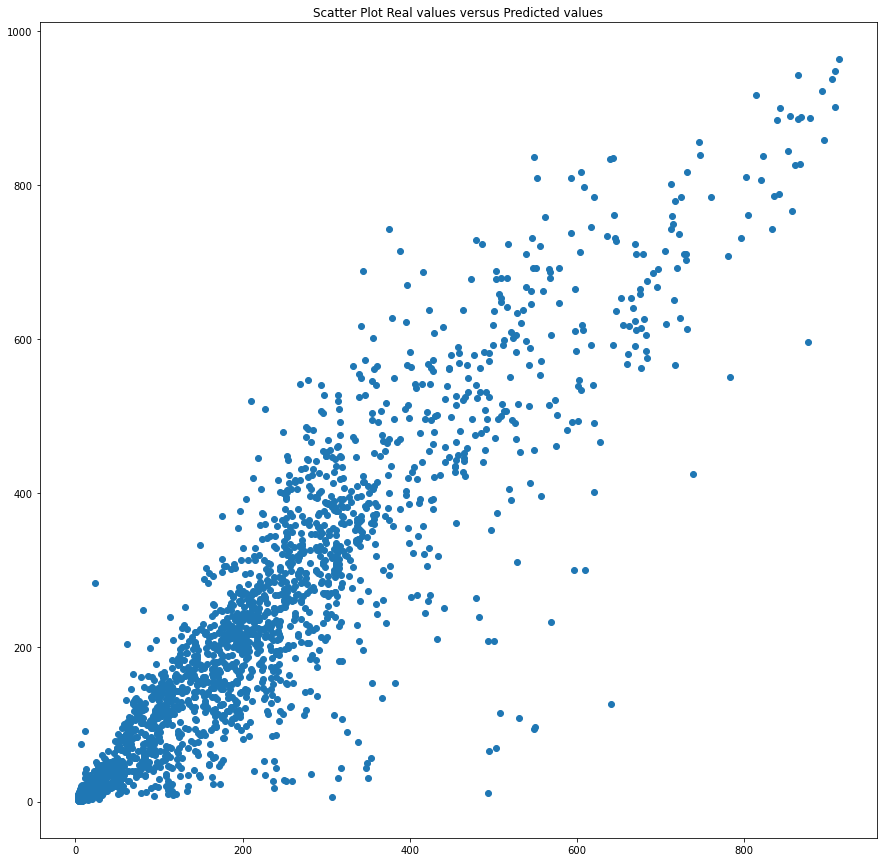

In [78]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(y_hat, y_test)
ax.set_title("Scatter Plot Real values versus Predicted values")

* Time features ordinal encoding and as numeric -- X
* weather sit manually giving ordinal integers and scale as numeric -- X
* outlier handling with IQR capping -- X 
* plotting 